#Weather Image Recognition

Donelli Francesco, ID: 5106106

Giadone Giuseppe, ID: 5110222

The goal of our analysis is to recognize and classify images based on weather conditions. 

First, import all useful libraries

In [ ]:
!pip install torch torchvision
!pip install d2l==1.0.0a1.post0
!pip install split-folders
#Libraries for neural network execution
import torch 
from torchvision import transforms, datasets
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
from d2l import torch as d2l
d2l.use_svg_display()
from torch import nn
from torch.nn import functional as F
#Libraries for data exploration
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import splitfolders
## Libraries for training and validation iterations 
from torch.utils.data import RandomSampler
from torch.utils.data import dataloader,DataLoader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 121 kB 74.4 MB/s 
     |████████████████████████████████| 1.6 MB 65.8 MB/s 
     |████████████████████████████████| 83 kB 3.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Import Dataset and Data Exploration

The dataset contains 6862 images divided in 11 classes, based on the weather condition in the image. 

It can be found at the following URL: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset

In [ ]:
#Loading images from google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DL/

Mounted at /content/drive
/content/drive/MyDrive/DL


In [ ]:
data_augmentation = transforms.Compose([transforms.Resize((224,224)), #images resize 
                   transforms.ToTensor(), 
    ]) # images are imported with original colors (not gray scale) and converted to tensors

In [ ]:
#Dataset definition with the specified data augmentation
my_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/W2/',
                                           transform=data_augmentation)
#create Data Loader
dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32, shuffle=True)

Below we provide some examples of images in the dataset

In [ ]:
#dictionary with the names of the labels in the dataset
weather_conditions = {0:'dew',1:'fogsmog',2:'frost',3:'glaze',4:'hail',5:'lightning',
                6:'rain',7:'rainbow',8:'rime',9:'sandstorm',10:'snow'} 

In [ ]:
images, labels=next(iter(dataloader)) #take some images from the dataset and the corresponding labels

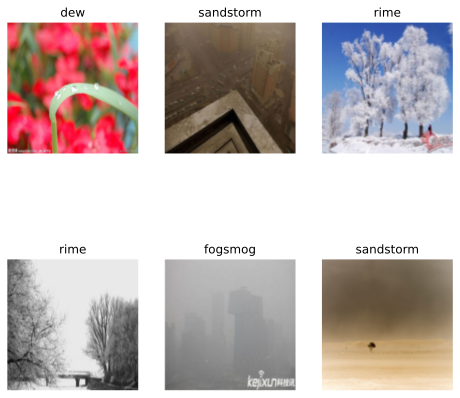

In [ ]:
#plot the images with the corresponding labels
fig,axes = plt.subplots(2,3,figsize=(8,8)) #we plot the images in 2 rows and 3 columnns, with a 8x8 size 
for i in range(2): #two rows
    for j in range(3): #three columns
        plt.sca(axes[i,j])
        idx = np.random.randint(0,31) #take random images from a batch of size 32
        image = np.moveaxis(images[idx].numpy(),0,2)
        plt.title(weather_conditions[labels[idx].item()]) #show the label
        plt.imshow(image) #plot the image
        plt.axis('off')

Now let's take a look at the distribution of the classes to see if they are balanced

In [ ]:
## we create our path to select the entire dataset on our Google Drive 
root_path='/content/drive/MyDrive/W2/'
## class_names is a list of all names of labels sorted in alphabetic order 
class_names_original = sorted(os.listdir(root_path))
n_class_original=len(class_names_original) #number of classes
## class_dis is a list of all lengths of each labels 
class_dis_original=[len(os.listdir(root_path + "/" + name)) for name in class_names_original]

In [ ]:
fig = px.bar(x = class_names_original, y = class_dis_original, text_auto='.2s', color = class_names_original) #create the histogram
fig.show() #show results

We see that "Rime" class is overrepresented so we remove 45% of images in that class

Since we have to rebalance a class, we create an empty folder "Rime2", with 55% of the images in original "Rime" folder and swap them in the folder with the complete dataset 

In [ ]:
splitfolders.ratio("/content/drive/MyDrive/rime", # The location of dataset
                   output="/content/drive/MyDrive/rime2", # The output location
                   seed=42, # The number of seed
                   ratio=(.55,.45), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 1160 files [00:23, 49.67 files/s] 


We renamed the folder with the correct number of images as "DL"

In [ ]:
## we create our path 
root_path='/content/drive/MyDrive/DL/' 
## class_names is a list of all names of labels sorted in alphabetic order 
class_names = sorted(os.listdir(root_path))
n_class=len(class_names)
## class_dis is a list of all lengths of each labels 
class_dis = [len(os.listdir(root_path + "/" + name)) for name in class_names]

In [ ]:
## We draw the labels after the adjustment 
fig = px.bar(x = class_names, y = class_dis, text_auto='.2s', color = class_names)
fig.show()

Now classes are balanced and we are ready to develop our neural network architectures

#Dataset division in train, validation and test for the analysis

In [ ]:
#re-set the dataset so that we have the right number of elements to work with (after rebalancing "Rime" class)
my_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/DL/',
                                           transform=data_augmentation)

## We split in train validation and test sets about 0.7,0.15,0.15 respectively 
train_set, val_set,test_set = torch.utils.data.random_split(my_dataset, [4439,951,951])

## We make train and test sets iterable in order to apply the neural network training function
train_iter=dataloader.DataLoader(train_set,batch_size=128,num_workers=0)
val_iter=dataloader.DataLoader(val_set,batch_size=30,num_workers=0)
test_iter=dataloader.DataLoader(test_set,batch_size=30,num_workers=0)

Validation set was used in many trials to decide which model was better to adopt, while final test was performed on test set

#First Neural Network Architecture

First, we define functions to evaluate accuracy and train the model. We use F.cross_entropy loss function from Functional module to prevent numerical over/under flowing with LogSumExp trick. We also added a decay factor of 0.001 to help avoid overfitting of the model

In [ ]:
def evaluate_accuracy(net, data_iter, device=None):

    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization
    net.apply(init_weights)
    print('training on', device)

    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.0001)##use Stochastic Gradient Descendent as optimizer, weight decay=0.001
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])## Define labels and limiter in the graph 
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) ## Move each minibatch of data to the GPU 
            y_hat = net(X)
            l = F.cross_entropy(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))## Define the position of each labels
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

We create another function to compare training and test losses in a graph. Since this function takes longer to run, we have to use it on a smaller amount of epochs. 

In [ ]:
#Define the total length of the batches for train and validation set 
total_batch=len(train_iter) #number of training images
def show_losses(model, val_iter):
  epochs=10 #number of epochs
  total_l_list=[] #initialize empty list
  validation_l_list=[] #initialize empty list
  validation_batch=len(val_iter) #number of test images. val_iter and test_iter have the same length
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001) #optimizer 
  for epoch in range(epochs):
    total_loss=0 #set loss to 0 at the start
    for num, data in enumerate(train_iter):
      X, y=data
      optimizer.zero_grad() 
      yhat=model.forward(X)
      loss=F.cross_entropy(yhat,y) #loss function
      total_loss+=loss #update total loss
      loss.backward()
      optimizer.step()
    total_l_list.append((total_loss/total_batch).detach().numpy()) #add the updated loss to the list
    with torch.no_grad():
      val_loss=0 #set loss to 0 at the start
      for num, data in enumerate(val_iter):
        val_x, val_y=data
        validation_out=model.forward(val_x)
        v_loss=F.cross_entropy(validation_out,val_y) #loss function
        val_loss+=v_loss #update total loss
      validation_l_list.append((val_loss/validation_batch).detach().numpy()) #add the updated loss to the list
  print(f'train loss: {total_loss/total_batch}')    #print results
  print(f'validation loss: {val_loss/validation_batch}')  #print results
  #plot results
  plt.plot([i for i in range(1,11)], [j for j in total_l_list], label='Train Loss') 
  plt.plot([i for i in range(1,11)], [j for j in validation_l_list], label='Test Loss') 
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Test and Train Loss')

Now we implement our first neural network. It is a CNN with 5 convolutions and 3 poolings. First two poolings are made with MaxPool to take into account for images with distinctive elements like rainbow or thunder. Last pooling is made with AvgPool since many images have distinct colors for the whole extent of the image, like a situation of sandstorm of fog.
We added batch normalization at the start of the net and another before Flatten() command. The net terminates with 4 linear layers and three Dropouts with probability of 0.15 each. ReLU() activation function was used as only activation function of the net

In [ ]:
my_net = nn.Sequential(nn.BatchNorm2d(3), # first Batch normalization
    nn.Conv2d(3, 96, kernel_size=5, stride=4, padding=1), nn.ReLU(), #ReLU activation function
    nn.MaxPool2d(kernel_size=3, stride=2), #Max Pool
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), #Max Pool
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(), #Convolution , ReLU activation function
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(), #Convolution , ReLU activation function
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(), #Convolution , ReLU activation function
    nn.AvgPool2d(kernel_size=2, stride=2), #Average Pool
    nn.BatchNorm2d(256),#second Batch Normalization
    nn.Flatten(),
    nn.Linear(9216, 6400), nn.ReLU(), #first layer, ReLU activation function
    nn.Dropout(p=0.15), #Dropout with prob. 0.15
    nn.Linear(6400, 4096), nn.ReLU(), #second layer, ReLU activiation function
    nn.Dropout(p=0.15), #Dropout with prob. 0.15
    nn.Linear(4096, 2048), nn.ReLU(), #third layer, ReLU activiation function
    nn.Dropout(p=0.15),
    nn.Linear(2048, 11)) #Dropout with prob. 0.15

Execution on validation set

loss 0.370, train acc 0.885, test acc 0.714
2112.4 examples/sec on cuda:0


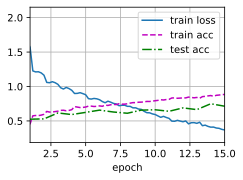

In [ ]:
#First, execute on validation set
lr, num_epochs = 0.01, 15
train(my_net, train_iter, val_iter, num_epochs, lr, device=d2l.try_gpu())

From the result is clear that we can detect a problem of **over-fitting**, the model is memorizing images in the training set, so classifies them with very high train accuracy and doesn't perform that well on validation set. We decide to increase Dropuout probability to 0.45 to solve this issue.

In [ ]:
my_net2= nn.Sequential(nn.BatchNorm2d(3), # first Batch normalization
    nn.Conv2d(3, 96, kernel_size=5, stride=4, padding=1), nn.ReLU(), #ReLU activation function
    nn.MaxPool2d(kernel_size=3, stride=2),  #First Max Pool
    #In this architecture, we used two Max Pool to first distinguish between the most important elements of the image (like Rainbow or Lightning)
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(), #Convolution , ReLU activiation function
    nn.MaxPool2d(kernel_size=3, stride=2), #Second Max Pool
    #Three consecutive convolutions
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),  #Convolution , ReLU activation function
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),  #Convolution , ReLU activation function
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),  #Convolution , ReLU activation function
    #At last we utilize Average Pool to classify basing on the whole extent of the image, to distinguish between conditions of that cover
    #the whole image like sand, snow, fogsmog or rain
    nn.AvgPool2d(kernel_size=2, stride=2),  #Average Pool
    nn.BatchNorm2d(256), #second Batch normalization
    nn.Flatten(),
    nn.Linear(9216, 6400), nn.ReLU(), #first layer, ReLU activation function
    nn.Dropout(p=0.45),
    nn.Linear(6400, 4096), nn.ReLU(), #second layer, ReLU activation function
    nn.Dropout(p=0.45),
    nn.Linear(4096, 2048), nn.ReLU(), #third layer, ReLU activation function
    nn.Dropout(p=0.45),
    nn.Linear(2048, 11))

Execution on test set

loss 0.831, train acc 0.709, test acc 0.706
1688.6 examples/sec on cuda:0


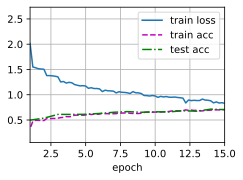

In [ ]:
#Execution on test set
lr, num_epochs = 0.01, 15
train(my_net2, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

train loss: 1.0591050386428833
validation loss: 1.076892614364624


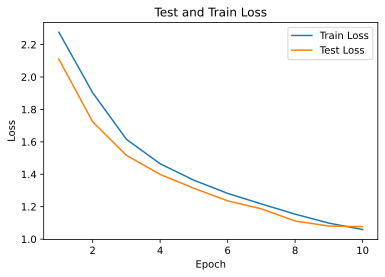

In [ ]:
#Comparison of train and test losses (10 epochs)
show_losses(my_net2, test_iter)

Increasing Dropout probability the model no longer memorizes elements by heart to classify them, but rather learns a classification pattern. Train accuracy is not as high as before, but that's the type of classification process we aim at when training a neural network.

#Second Neural Network Architecture

We create a "personalized" GoogLeNet wich consists in a combination of 
concatenated multi-branch convolutions (Inception blocks) in order to explore the image in a variety of filter sizes. 
The intuition is that the details at different positions can be recognized in an efficient way.

In [ ]:
## Our Inception blocks consists in 5 paths concatenated. 
class Inception(nn.Module):
    ## `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4,c5, **kwargs): 
        super(Inception, self).__init__(**kwargs)
        ## Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        ## Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        ## convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        ## Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        ## convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        ## Path 4 is a 3 x 3 convolutional layer followed by a 1 x 1
        ## convolutional layer
        self.p4_1 = nn.Conv2d(in_channels,c4[0],kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(c4[0], c4[1], kernel_size=1)
        ## Path 5 is a 3x3 maximum pooling layer followed by a 1 x 1
        ## convolutional layer
        self.p5_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p5_2=nn.Conv2d(in_channels,c5,kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(F.relu(self.p4_1(x))))
        p5=F.relu(self.p5_2(self.p5_1(x)))
        ## Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4,p5), dim=1)

Now we construct 5 blocks for the network

In [ ]:
## Block 1 uses 128 channels and a 7x7 convolutional layer
b1 = nn.Sequential(nn.Conv2d(3, 128, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.BatchNorm2d(128),
                   nn.Conv2d(128,96,kernel_size=7,stride=2,padding=3),
                   nn.ReLU(),
                   nn.Conv2d(96,100,kernel_size=7,stride=2,padding=3),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b2 = nn.Sequential(nn.Conv2d(100, 128, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(128, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.BatchNorm2d(192),
                   nn.Dropout(0.12),
                   nn.Conv2d(192,256,kernel_size=3,padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Now we define the inception blocks. In our case we have 7 inception blocks

In [ ]:
b3 = nn.Sequential(Inception(256, 128, (96, 128), (16, 32), (32,64),64),
                   Inception(416, 128, (128, 192), (32, 96),(64,96),64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b4 = nn.Sequential(Inception(576, 128, (96, 208), (16, 48), (64,78),64),
                   Inception(526, 128, (112, 224), (24, 64), (64,120),64),
                   Inception(600, 128, (128, 352), (24, 64), (64,96),64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:

b5 = nn.Sequential(Inception(704, 256, (160, 320), (32, 128), (128,222),128),
                   Inception(1054, 384, (192, 384), (48, 128), (128,352),128),
                   nn.AdaptiveAvgPool2d((1,1)), ##argument (1,1) is the required outpu shape
                   nn.Flatten())

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1376, 11))

loss 0.712, train acc 0.752, test acc 0.601
1492.3 examples/sec on cuda:0


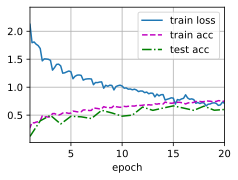

In [ ]:
## we define epochs,the learning rate and apply training function to our net
#Execution on validation set
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1376, 11))
lr, num_epochs= 0.05, 20
d2l.train_ch6(net, train_iter, val_iter, num_epochs, lr, device=d2l.try_gpu())

loss 0.708, train acc 0.749, test acc 0.626
1492.7 examples/sec on cuda:0


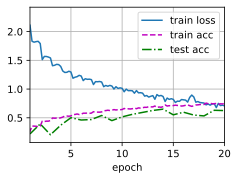

In [ ]:
## we define epochs,the learning rate and apply training function to our net
#Execution on test set
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1376, 11))
lr, num_epochs= 0.05, 20
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

train loss: 2.379021406173706
validation loss: 2.3799633979797363


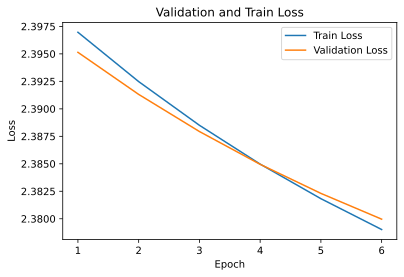

In [ ]:
#Comparison of train and test losses (6 epochs)
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1376, 11))
show_losses(net, test_iter)

The model does not show signs of over/under fitting, so there is not need to increase Dropout, weight decay factor or try early stopping

#Conclusions

The first model performs better in term of accuracy, reaching 70% in 15 epochs, and is less expensive to execute in terms of time and code implementation, so is the one we prefer to classify the images of this dataset. A difference between the two architecture is the learning parameter, set to 0.05 in the second neural network. Going for trial and error, this is the learning paramether that gave us the best results. We have to mention that the second model has the advantage to have closer test and train losses, but at the same time these losses are higher than the ones of the first model